# **1.  Geliştirme Ortamının Hazırlanması ve CUDA Kontrolü**

Bu bölümde, derin öğrenme ve bilgisayarla görme (computer vision) projelerinde kullanılacak temel kütüphaneler yüklenmekte ve **CUDA** desteği kontrol edilmektedir.  
CUDA, GPU kullanarak PyTorch işlemlerinin çok daha hızlı yapılmasını sağlar.  

---

## **Kodun İşlevleri**

### **1. Kütüphanelerin İçe Aktarılması (Imports)**
- **pandas** ve **numpy**: Veri analizi ve sayısal işlemler için.
- **matplotlib.pyplot**: Görselleştirme ve grafik çizimi.
- **cv2** (**OpenCV**): Görüntü işleme fonksiyonları.
- **torch** ve **torch.utils.data**: Derin öğrenme modelleri ve veri yükleme işlemleri.
- **torchvision.models**: Hazır derin öğrenme modellerine erişim.
- **warnings**: Gereksiz uyarıların kapatılması.
- **os**: Dosya ve dizin işlemleri.

---

### **2. CUDA Kontrolü**
Kodun sonunda, sisteminizde GPU desteği olup olmadığı kontrol edilir.

- **GPU mevcutsa**:
  - CUDA'nın kullanılabilirliği, sayısı ve adı ekrana yazdırılır.

- **GPU yoksa**:
  - İşlemlerin CPU üzerinde yapılacağı belirtilir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelEncoder
import cv2
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd

# Kontrol Kısımı
if torch.cuda.is_available():
    print("CUDA is available")
    print("Number of GPU devices:", torch.cuda.device_count())
    print("Current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available for profit. CPU will be used.")

CUDA is available
Number of GPU devices: 1
Current device name: Tesla P100-PCIE-16GB


# **2. Veri Ön İşleme ve DataLoader Hazırlığı**

Bu bölümde, **araç markası sınıflandırma** problemi için veri seti hazırlanır ve modelin eğitimi sırasında kullanılmak üzere uygun formatta dönüştürülür.  
Ayrıca **data augmentation (veri artırma)** teknikleri uygulanarak modelin genelleme yeteneği güçlendirilir.

---

## **1. Veri Setinin İncelenmesi**

İlk olarak, eğitim verilerinin bulunduğu klasördeki her markaya ait görsel sayısı hesaplanır.  
Bu adım, **veri dağılımını** anlamak ve olası **dengesizlikleri** tespit etmek için önemlidir.

**İşlemler:**
- `os.listdir()` ile her klasördeki dosyalar sayılır.
- Sonuçlar bir `pandas.DataFrame` içine kaydedilir.
- Görseller en çoktan en aza doğru sıralanır.

---

## **2. Veri Yollarının Tanımlanması**

Projenin veri seti, üç alt klasöre ayrılmıştır:
- **train/** → Modelin eğitileceği veriler  
- **val/** → Modelin doğrulama aşamasında kullanılacak veriler  
- **test/** → Modelin hiç görmediği test verileri  

Bu dizinlere kolay erişim için Python'da yol (`path`) değişkenleri tanımlanır.

---

## **3. Görüntü Dönüşümleri ve Data Augmentation**

Modelin daha iyi genelleştirmesi için **eğitim verilerine çeşitli dönüşümler uygulanır**.  
Bu işlemler, özellikle görüntülerin farklı açılardan, ışık koşullarında ve ölçeklerde modellenmesini sağlar.

### **Eğitim Dönüşümleri (`train_transforms`)**
- `Resize(224, 224)` → Görsellerin sabit boyuta getirilmesi  
- `RandomHorizontalFlip(p=0.5)` → Yatayda rastgele çevirme (%50 olasılıkla)  
- `RandomRotation(30)` → Rastgele döndürme (±30°)  
- `ColorJitter` → Parlaklık, kontrast ve doygunluk değişiklikleri  
- `RandomResizedCrop` → Görsellerin belirli bir oranda kırpılması  
- `RandomAffine` → Konumlandırmada küçük kaydırmalar  
- `ToTensor()` → Görselleri tensör formatına dönüştürme  
- `Normalize` → Görselleri standart normal dağılıma uygun şekilde normalize etme

### **Doğrulama ve Test Dönüşümleri (`val_test_transforms`)**
- Sadece `Resize`, `ToTensor` ve `Normalize` işlemleri yapılır.  
  Böylece doğrulama/test verileri sabit ve tutarlı kalır.

---

## **4. Dataset ve DataLoader Hazırlığı**

PyTorch'un `ImageFolder` yapısı kullanılarak veri seti okunur:  
- **train_dataset** → Eğitim verileri  
- **val_dataset** → Doğrulama verileri  
- **test_dataset** → Test verileri  

Daha sonra `DataLoader` nesneleri ile veriler **mini-batch**'ler halinde GPU/CPU'ya yüklenir.

**DataLoader Parametreleri:**
- `batch_size=16` → Her adımda 16 görsel işlenir.  
- `shuffle=True` → Eğitim verilerinde sıralama her epoch başında karıştırılır.  
- `num_workers=4` → Çoklu iş parçacığı ile veri yükleme hızlandırılır.  
- `pin_memory=True` → GPU transferi hızlandırılır.

In [2]:
dataset_path = "/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset/train"

image_counts = {}
for brand in os.listdir(dataset_path):
    brand_path = os.path.join(dataset_path, brand)
    if os.path.isdir(brand_path): 
        image_counts[brand] = len(os.listdir(brand_path))

df = pd.DataFrame(list(image_counts.items()), columns=["Brand", "Image Count"])
print(df.sort_values(by="Image Count", ascending=False))

# Veri yolları
data_dir = "/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Görüntü dönüşümleri & Data Augmentation
import torchvision.transforms as transforms
import torchvision.datasets as datasets

img_size = 300  # EfficientNetB3 input size
batch_size = 16

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset ve DataLoader
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"📂 Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

            Brand  Image Count
0          Nissan          349
1            Ford          349
2         Hyundai          349
3   Mercedes-Benz          349
4        Chrysler          349
5             GMC          349
6         Lincoln          349
7            FIAT          349
8    Aston Martin          349
9      Volkswagen          349
10     Land Rover          349
11          Buick          349
12          Honda          349
13          Dodge          349
14        Porsche          349
15            Kia          349
16         Toyota          349
17           Jeep          349
18          Volvo          349
19     Mitsubishi          349
20       Cadillac          349
21      Chevrolet          349
22         Jaguar          349
23        Bentley          349
24            BMW          349
25          Lexus          349
26           Audi          349
27       INFINITI          349
28          Acura          349
29         Subaru          349
30          Mazda          349
31      

# **3. Modelin Eğitilmesi: EfficientNet-B3 Tabanlı Derin Öğrenme Modeli**

Bu bölümde, araç markalarının sınıflandırılması için **EfficientNet-B3** tabanlı bir derin öğrenme modeli tasarlanmakta ve eğitim süreci için gerekli yapı taşları tanımlanmaktadır.

---

## **1. Cihaz (Device) Ayarları**
Modelin GPU veya CPU üzerinde çalışması belirlenir:
- Eğer CUDA destekli bir **GPU** mevcutsa, model GPU üzerinde eğitilir.
- Aksi durumda, hesaplamalar **CPU** üzerinden yapılır.

---

## **2. EfficientNet-B3 Modelinin Kullanımı**
EfficientNet, yüksek performanslı ve optimize edilmiş bir **CNN mimarisi**dir.  
Bu projede **EfficientNet-B3**, `torchvision.models` kütüphanesinden **ImageNet ön eğitimli ağırlıklar (IMAGENET1K_V1)** ile yüklenir.

- Modelin **feature extractor** kısmı sabit tutulur.
- Son katman yerine **özel bir sınıflandırma bloğu** eklenir.

---

## **3. Özel Model Mimarisinin Tasarımı**

`CustomEfficientNet` sınıfı, EfficientNet'in üzerine özelleştirilmiş bir **fully connected (FC)** katman yapısı ekler.

### **Mimari Detaylar:**
1. **Giriş:** EfficientNet'in "features" katmanından gelen özellik haritaları.
2. `AdaptiveAvgPool2d(1)` → Özellik haritasını tek boyuta indirger.
3. **Classifier Bloğu:**
   - `Flatten` → Veriyi vektörleştirir.
   - `Linear(1536 → 512)` → İlk tam bağlantılı katman.
   - `LayerNorm` + `ReLU6` → Normalizasyon ve aktivasyon.
   - `Dropout(0.4)` → Aşırı öğrenmeyi (overfitting) engeller.
   - `Linear(512 → 256)` → İkinci tam bağlantılı katman.
   - `LayerNorm` + `ReLU6`
   - `Dropout(0.3)`
   - `Linear(256 → num_classes)` → Çıkış katmanı (sınıf sayısı kadar nöron).

**Avantajı:** Daha karmaşık ve güçlü bir sınıflandırıcı, modelin veri setine daha iyi uyum sağlamasını sağlar.

---

## **4. Kayıp Fonksiyonu ve Optimizasyon**

### **Kayıp Fonksiyonu (Loss Function)**
- `nn.CrossEntropyLoss()` → Çok sınıflı sınıflandırma problemleri için uygundur.

### **Optimizer**
- **AdamW** → Adam algoritmasının ağırlık çürümesi (weight decay) ile geliştirilmiş versiyonu.
- Öğrenme oranı: `lr=5e-5`
- Weight decay: `1e-3` (regularization)

### **Öğrenme Oranı Zamanlayıcısı (Scheduler)**
- `ReduceLROnPlateau`:
  - **Doğrulama doğruluğu** (validation accuracy) belirli bir süre iyileşmezse öğrenme oranını yarıya düşürür.
  - `factor=0.5`, `patience=2`

---

## **5. Mixed Precision Training (AMP)**

Hafıza ve hız optimizasyonu için **Automatic Mixed Precision (AMP)** kullanılır:
- `autocast` → Hesaplamaları otomatik olarak **16-bit (half precision)** ve **32-bit (full precision)** arasında dengeler.
- `GradScaler` → Ağırlıkların doğru şekilde güncellenmesini sağlar.

**Avantajları:**
- Daha düşük GPU bellek kullanımı
- Daha hızlı eğitim süresi


In [3]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# EfficientNet tabanlı model
num_classes = len(train_dataset.classes)
base_model = efficientnet_b3(weights="IMAGENET1K_V1")

class CustomEfficientNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.features = base_model.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1536, 512),
            nn.LayerNorm(512),
            nn.ReLU6(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU6(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = CustomEfficientNet(base_model, num_classes).to(device)
print("✅ EfficientNet-B3 Model Modified Successfully!")

# Kayıp fonksiyonu, optimizer ve scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()  #  Mixed Precision Training

🚀 Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 184MB/s]


✅ EfficientNet-B3 Model Modified Successfully!


# **4. Modelin Değerlendirilmesi ve Eğitim Döngüsü**

Bu bölümde, eğitilmiş modelin performansı ölçülür ve eğitim süreci yönetilir.  
Modelin doğruluk oranı hesaplanır, erken durdurma (early stopping) uygulanır ve en iyi model kaydedilir.

---

## **1. Model Değerlendirme Fonksiyonu (`evaluate`)**
- Modeli **evaluation mod**una alır (`model.eval()`).
- Verilen veri yükleyici (`loader`) üzerinden geçerek:
  - Modelin tahminleri alınır.
  - Tahminler ile gerçek etiketler karşılaştırılır.
  - **Doğruluk oranı (accuracy)** hesaplanır.

- `torch.no_grad()` ile gradient hesaplamaları devre dışı bırakılarak hafıza ve işlem süresi optimizasyonu sağlanır.

---

## **2. Eğitim Fonksiyonu (`train`)**

### **Ana Adımlar:**
1. **Cihaz seçimi:** GPU varsa kullanılır, yoksa CPU.
2. **Kayıp fonksiyonu ve optimizer:**
   - `CrossEntropyLoss` → Çok sınıflı sınıflandırma için uygun.
   - `AdamW` optimizer ile ağırlık güncellenir.
3. **Scheduler:** `StepLR` ile belirli epoch aralıklarında öğrenme oranı düşürülür.
4. **Mixed Precision Training:** `autocast` ve `GradScaler` ile hesaplamalar hızlandırılır ve GPU belleği optimize edilir.

### **Epoch Döngüsü:**
- Her epoch için:
  - Model **training mod**una alınır.
  - Mini-batchler üzerinden:
    - Tahminler yapılır ve kayıp hesaplanır.
    - Gradientler geri yayılır ve optimizer ile ağırlıklar güncellenir.
    - **Kısmî doğruluk** ve kayıp değeri sürekli güncellenir.
  - Eğitim doğruluğu (`train_acc`) ve doğrulama doğruluğu (`val_acc`) hesaplanır.
  - Eğer doğrulama doğruluğu en yüksek değeri geçerse model kaydedilir (`best_model.pth`).

### **Early Stopping:**
- Belirli sayıda epoch boyunca doğrulama doğruluğu iyileşmezse eğitim durdurulur.
- Böylece **overfitting** önlenir.

---

## **3. Fonksiyonların Avantajları**
- Model performansını her epoch sonunda izleme.
- En iyi modeli kaydetme ve gereksiz eğitim süresini azaltma.
- Mixed precision ile daha hızlı ve verimli eğitim.

---

Bu yapı ile model, hem performansını sürekli takip eder hem de eğitim süreci optimize edilmiş şekilde tamamlanır.


In [4]:
from tqdm import tqdm

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

def train(model, train_loader, val_loader, epochs=20, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    scaler = GradScaler()
    best_acc, counter = 0.0, 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / (total // train_loader.batch_size + 1), acc=correct / total)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        print(f"📊 Epoch [{epoch+1}/{epochs}] - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Model saved!")
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"⏹️ Early stopping after {epoch+1} epochs. Best Val Acc: {best_acc:.4f}")
            break

        scheduler.step()
    print("🎯 Training complete!")

# **5. Hiperparametre Optimizasyonu**

Bu bölümde, modelin performansını artırmak için **öğrenme hızı (LR), batch size, dropout oranı, optimizer ve scheduler** gibi hiperparametreler üzerinde denemeler yapılabilir.  
Şu anda model **AdamW optimizer**, **StepLR scheduler** ve belirli dropout oranları ile eğitilmektedir.  

- `epochs`: Modelin tüm eğitim verisi üzerinde kaç kez eğitim yapacağını belirler.  
- `patience`: Early stopping mekanizmasında, doğrulama doğruluğu iyileşmediğinde kaç epoch bekleyeceğini belirler.  

In [5]:
# Şov Devam Etmeli
train(model, train_loader, val_loader, epochs=50, patience=5)

Epoch [1/50]: 100%|██████████| 720/720 [01:38<00:00,  7.29it/s, acc=0.0676, loss=3.43]


📊 Epoch [1/50] - Train Acc: 0.0676, Val Acc: 0.1402
✅ Model saved!


Epoch [2/50]: 100%|██████████| 720/720 [01:38<00:00,  7.32it/s, acc=0.179, loss=3.04]


📊 Epoch [2/50] - Train Acc: 0.1793, Val Acc: 0.3063
✅ Model saved!


Epoch [3/50]: 100%|██████████| 720/720 [01:38<00:00,  7.31it/s, acc=0.299, loss=2.63]


📊 Epoch [3/50] - Train Acc: 0.2994, Val Acc: 0.4424
✅ Model saved!


Epoch [4/50]: 100%|██████████| 720/720 [01:38<00:00,  7.28it/s, acc=0.407, loss=2.23]


📊 Epoch [4/50] - Train Acc: 0.4075, Val Acc: 0.5244
✅ Model saved!


Epoch [5/50]: 100%|██████████| 720/720 [01:38<00:00,  7.32it/s, acc=0.494, loss=1.91]


📊 Epoch [5/50] - Train Acc: 0.4937, Val Acc: 0.5806
✅ Model saved!


Epoch [6/50]: 100%|██████████| 720/720 [01:39<00:00,  7.26it/s, acc=0.57, loss=1.61]


📊 Epoch [6/50] - Train Acc: 0.5699, Val Acc: 0.6020
✅ Model saved!


Epoch [7/50]: 100%|██████████| 720/720 [01:38<00:00,  7.31it/s, acc=0.607, loss=1.46]


📊 Epoch [7/50] - Train Acc: 0.6066, Val Acc: 0.6457
✅ Model saved!


Epoch [8/50]: 100%|██████████| 720/720 [01:38<00:00,  7.32it/s, acc=0.644, loss=1.33]


📊 Epoch [8/50] - Train Acc: 0.6437, Val Acc: 0.6501
✅ Model saved!


Epoch [9/50]: 100%|██████████| 720/720 [01:37<00:00,  7.38it/s, acc=0.676, loss=1.21]


📊 Epoch [9/50] - Train Acc: 0.6757, Val Acc: 0.6622
✅ Model saved!


Epoch [10/50]: 100%|██████████| 720/720 [01:37<00:00,  7.37it/s, acc=0.703, loss=1.1]


📊 Epoch [10/50] - Train Acc: 0.7028, Val Acc: 0.6820
✅ Model saved!


Epoch [11/50]: 100%|██████████| 720/720 [01:38<00:00,  7.32it/s, acc=0.737, loss=0.981]


📊 Epoch [11/50] - Train Acc: 0.7372, Val Acc: 0.6885
✅ Model saved!


Epoch [12/50]: 100%|██████████| 720/720 [01:38<00:00,  7.32it/s, acc=0.755, loss=0.91]


📊 Epoch [12/50] - Train Acc: 0.7551, Val Acc: 0.6990
✅ Model saved!


Epoch [13/50]: 100%|██████████| 720/720 [01:38<00:00,  7.31it/s, acc=0.763, loss=0.875]


📊 Epoch [13/50] - Train Acc: 0.7627, Val Acc: 0.7038
✅ Model saved!


Epoch [14/50]: 100%|██████████| 720/720 [01:38<00:00,  7.28it/s, acc=0.775, loss=0.822]


📊 Epoch [14/50] - Train Acc: 0.7753, Val Acc: 0.7115
✅ Model saved!


Epoch [15/50]: 100%|██████████| 720/720 [01:38<00:00,  7.29it/s, acc=0.785, loss=0.791]


📊 Epoch [15/50] - Train Acc: 0.7847, Val Acc: 0.7059


Epoch [16/50]: 100%|██████████| 720/720 [01:38<00:00,  7.30it/s, acc=0.806, loss=0.73]


📊 Epoch [16/50] - Train Acc: 0.8064, Val Acc: 0.7115


Epoch [17/50]: 100%|██████████| 720/720 [01:37<00:00,  7.41it/s, acc=0.807, loss=0.715]


📊 Epoch [17/50] - Train Acc: 0.8068, Val Acc: 0.7099


Epoch [18/50]: 100%|██████████| 720/720 [01:38<00:00,  7.33it/s, acc=0.818, loss=0.679]


📊 Epoch [18/50] - Train Acc: 0.8177, Val Acc: 0.7188
✅ Model saved!


Epoch [19/50]: 100%|██████████| 720/720 [01:38<00:00,  7.34it/s, acc=0.82, loss=0.662]


📊 Epoch [19/50] - Train Acc: 0.8203, Val Acc: 0.7147


Epoch [20/50]: 100%|██████████| 720/720 [01:38<00:00,  7.29it/s, acc=0.826, loss=0.649]


📊 Epoch [20/50] - Train Acc: 0.8258, Val Acc: 0.7184


Epoch [21/50]: 100%|██████████| 720/720 [01:37<00:00,  7.36it/s, acc=0.828, loss=0.633]


📊 Epoch [21/50] - Train Acc: 0.8280, Val Acc: 0.7152


Epoch [22/50]: 100%|██████████| 720/720 [01:37<00:00,  7.37it/s, acc=0.828, loss=0.624]


📊 Epoch [22/50] - Train Acc: 0.8281, Val Acc: 0.7176


Epoch [23/50]: 100%|██████████| 720/720 [01:39<00:00,  7.27it/s, acc=0.839, loss=0.595]


📊 Epoch [23/50] - Train Acc: 0.8389, Val Acc: 0.7232
✅ Model saved!


Epoch [24/50]: 100%|██████████| 720/720 [01:38<00:00,  7.28it/s, acc=0.84, loss=0.589]


📊 Epoch [24/50] - Train Acc: 0.8400, Val Acc: 0.7244
✅ Model saved!


Epoch [25/50]: 100%|██████████| 720/720 [01:38<00:00,  7.30it/s, acc=0.837, loss=0.595]


📊 Epoch [25/50] - Train Acc: 0.8368, Val Acc: 0.7317
✅ Model saved!


Epoch [26/50]: 100%|██████████| 720/720 [01:38<00:00,  7.34it/s, acc=0.846, loss=0.567]


📊 Epoch [26/50] - Train Acc: 0.8456, Val Acc: 0.7273


Epoch [27/50]: 100%|██████████| 720/720 [01:37<00:00,  7.38it/s, acc=0.851, loss=0.558]


📊 Epoch [27/50] - Train Acc: 0.8514, Val Acc: 0.7273


Epoch [28/50]: 100%|██████████| 720/720 [01:37<00:00,  7.42it/s, acc=0.846, loss=0.559]


📊 Epoch [28/50] - Train Acc: 0.8464, Val Acc: 0.7184


Epoch [29/50]: 100%|██████████| 720/720 [01:37<00:00,  7.37it/s, acc=0.853, loss=0.539]


📊 Epoch [29/50] - Train Acc: 0.8528, Val Acc: 0.7313


Epoch [30/50]: 100%|██████████| 720/720 [01:36<00:00,  7.44it/s, acc=0.855, loss=0.532]


📊 Epoch [30/50] - Train Acc: 0.8553, Val Acc: 0.7301
⏹️ Early stopping after 30 epochs. Best Val Acc: 0.7317
🎯 Training complete!


# **6. Modelin Değerlendirilmesi: Confusion Matrix & Grad-CAM**

Bu bölümde, eğitilmiş modelin performansı **Confusion Matrix** ve **Grad-CAM** ile görselleştirilir.  
Hem modelin hangi sınıflarda başarılı olduğunu görmek hem de karar mekanizmasını incelemek amaçlanır.

---

## **1. Confusion Matrix**
- Modelin tahmin ettiği sınıflar ile gerçek sınıflar arasındaki ilişkiyi gösterir.
- Sıcaklık haritası (heatmap) ile görselleştirilir.
- Böylece hangi sınıfların karıştırıldığı kolayca tespit edilebilir.

---

## **2. Grad-CAM (Gradient-weighted Class Activation Mapping)**
- Modelin **hangi bölgelere bakarak** tahmin yaptığını görselleştirir.
- Son convolution bloğundan gelen aktivasyonlar ve gradientler kullanılarak heatmap oluşturulur.
- Heatmap, orijinal görüntüye bindirilir ve modelin dikkat ettiği bölgeler görselleştirilir.

---

Bu iki yöntem, modelin **performansını hem nicel hem de görsel olarak değerlendirmeyi** sağlar ve yanlış sınıflamaların anlaşılmasına yardımcı olur.


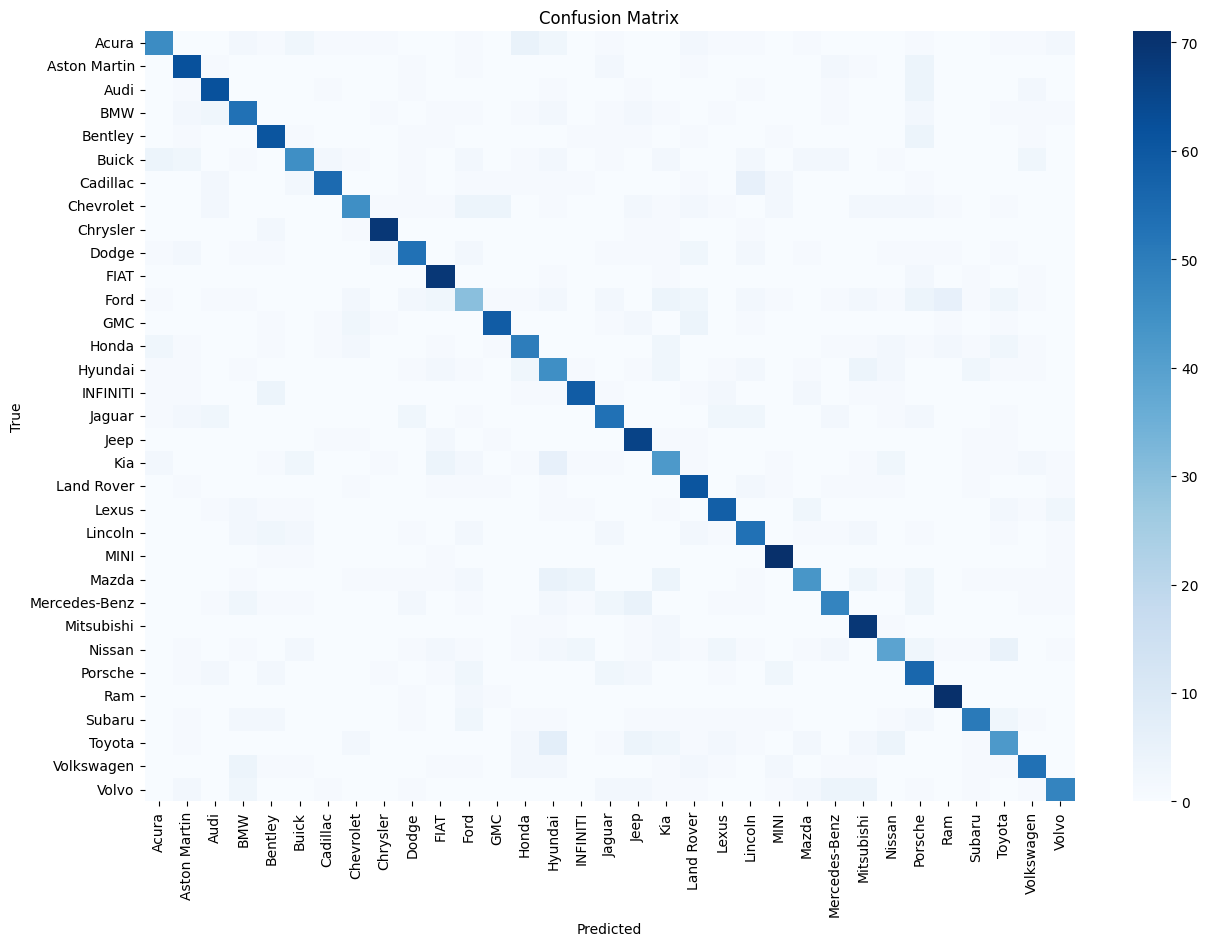


Classification Report:

               precision    recall  f1-score   support

        Acura       0.77      0.61      0.68        75
 Aston Martin       0.75      0.83      0.78        75
         Audi       0.79      0.83      0.81        75
          BMW       0.69      0.71      0.70        75
      Bentley       0.73      0.81      0.77        75
        Buick       0.73      0.60      0.66        75
     Cadillac       0.87      0.73      0.80        75
    Chevrolet       0.75      0.60      0.67        75
     Chrysler       0.88      0.92      0.90        75
        Dodge       0.73      0.71      0.72        75
         FIAT       0.76      0.92      0.83        75
         Ford       0.48      0.40      0.44        75
          GMC       0.86      0.79      0.82        75
        Honda       0.70      0.67      0.68        75
      Hyundai       0.52      0.60      0.56        75
     INFINITI       0.82      0.79      0.80        75
       Jaguar       0.70      0.71     

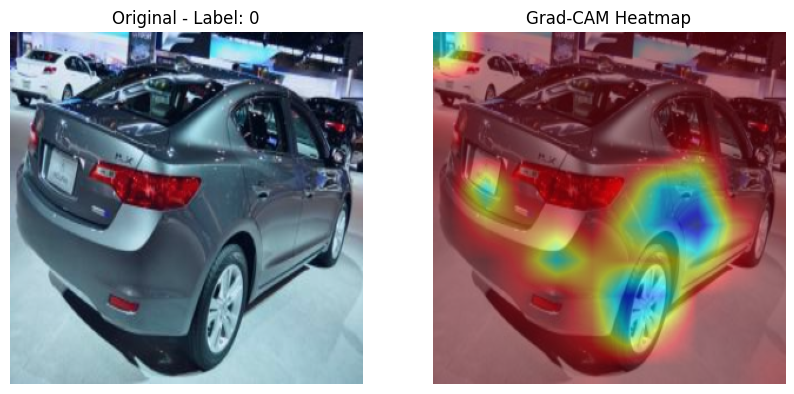

In [6]:
#Confusion Matrix & Grad-CAM

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, loader, classes):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))


# Grad-CAM Görselleştirme
from torch.nn import functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None
        # Hook: target layer’dan hem aktivasyonları hem de grad'leri alacağız
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_image, target_class=None):
        input_image = input_image.unsqueeze(0).to(device)

        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        # Grad-CAM hesaplama
        gradients = self.gradients.detach().cpu().numpy()[0]
        activations = self.activations.detach().cpu().numpy()[0]
        weights = gradients.mean(axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (300, 300))
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam

# Örnek görselleştirme
def show_gradcam_example(model, dataset, gradcam):
    img, label = dataset[0]  # İlk örneği alalım
    cam = gradcam.generate_cam(img, target_class=label)

    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    superimposed_img = heatmap + img_np
    superimposed_img = superimposed_img / superimposed_img.max()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original - Label: {label}")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

# Confusion Matrix çizdir
plot_confusion_matrix(model, test_loader, train_dataset.classes)

# Grad-CAM örneği
gradcam = GradCAM(model, model.features[-1])  # EfficientNet son convolution bloğu
show_gradcam_example(model, test_dataset, gradcam)


# **7. Modelin Değerlendirilmesi: Accuracy & Loss Grafikler**

Bu bölümde, modelin eğitim sürecindeki performansı **grafiklerle görselleştirilir**.  
Hem kayıp (loss) hem de doğruluk (accuracy) değerleri izlenerek modelin öğrenme durumu analiz edilir.

---

## **1. Kayıp ve Doğruluk Takibi**
- Eğitim ve doğrulama doğruluğu ile eğitim kaybı her epoch sonunda kaydedilir.
- Böylece modelin:
  - **Overfitting** yapıp yapmadığı
  - **Öğrenme hızının** uygun olup olmadığı
  - Eğitim sürecinde hangi epochlarda iyileşme sağlandığı  
  kolayca takip edilebilir.

---

## **2. Eğitim Grafikleri**
- **Training Loss:** Eğitim sırasında kaybın nasıl değiştiğini gösterir.
- **Train & Validation Accuracy:** Hem eğitim hem doğrulama doğruluğunu aynı grafikte karşılaştırır.
- Bu grafikler sayesinde:
  - Modelin hangi noktada en iyi performansı gösterdiği
  - Early stopping veya hiperparametre ayarlamalarının etkisi
  hızlıca gözlemlenebilir.

---

Grafiklerin çizimi, eğitim tamamlandıktan sonra yapılır ve modelin performans trendlerini görselleştirir.


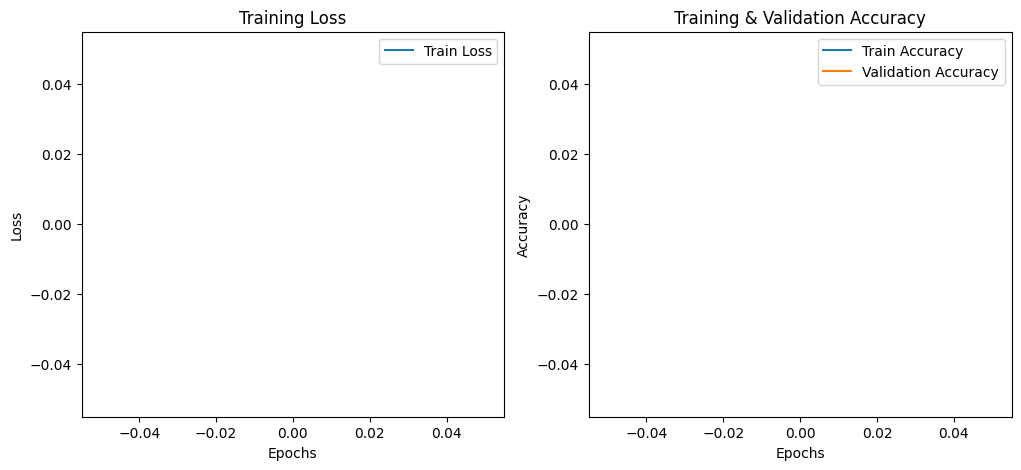

In [7]:
#Accuracy & Loss Grafikleri

train_losses, val_accuracies, train_accuracies = [], [], []

def train(model, train_loader, val_loader, epochs=20, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    scaler = GradScaler()
    best_acc, counter = 0.0, 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss / (total // train_loader.batch_size + 1), acc=correct / total)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)

        # Kayıt tut
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"📊 Epoch [{epoch+1}/{epochs}] - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Model saved!")
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"⏹️ Early stopping after {epoch+1} epochs. Best Val Acc: {best_acc:.4f}")
            break

        scheduler.step()
    print(" Training complete!")


# Eğitim Sonucu Grafikleri


def plot_training_curves():
    # Bu fonksiyon, her epoch sonunda kaydedilen eğitim kaybı ve eğitim/doğrulama doğruluklarını görselleştirir.
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()

plot_training_curves()
